### **Preparation**

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import math
import csv
from google.colab import files
from collections import deque

### **Input data**
- load the data file ('mnist.csv')
- each row of the data consists of the label `l` and the image pixel values `x` in a vector form
- the label is one of the 10 digits from 0 to 9
- the image represents its associated label in the grey scale
- the number of images is 10,000 and the size of each image is 28x28, $x \in \mathbb{R}^{784}$
- consider the first 1,000 images for training and the rest 9,000 images for testing
- normalise the intensity values of each image so that they ranges from 0 to 1


In [2]:
uploaded = files.upload()

Saving mnist.csv to mnist.csv


In [0]:
file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)   #10000개
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
train_image  = np.empty((size_row * size_col, 1000))
train_label  = np.empty(1000, dtype=int)
test_image  = np.empty((size_row * size_col, 9000))
test_label  = np.empty(9000, dtype=int)

for line in data:
    if count < 1000 :
      line_data   = line.split(',')
      label       = line_data[0]
      im_vector   = np.asfarray(line_data[1:])
      im_vector   = normalize(im_vector)

      train_label[count]       = label       # size : 10000
      train_image[:, count]    = im_vector   # size : 784 * 10000

    else: 
      line_data   = line.split(',')
      label       = line_data[0]
      im_vector   = np.asfarray(line_data[1:])
      im_vector   = normalize(im_vector)

      test_label[count-1000]       = label       # size : 10000
      test_image[:, count-1000]    = im_vector   # size : 784 * 10000

    count += 1

train_costs = deque()
test_costs = deque()
theta_0s = deque()
theta_1s = deque()
theta_2s = deque()
bias_0s = deque()
bias_1s = deque()
bias_2s = deque()
iters = deque()
train_accuracys = deque()
test_accuracys = deque()
incorrect_predicts = deque()

#correct_labels = []
correct_labels = deque()
#incorrect_labels = []
incorrect_labels = deque()

#print(num_image)  #10000
#print(len(train_image))  #784
#print(len(train_image[0]))  #1000
#print(len(train_label))  #1000
#print(len(test_image))  #784
#print(len(test_image[0]))  #9000
#print(len(test_label))  #9000
#print(train_image.shape)

train_length = len(train_label)
train_l = np.zeros((10,1000))
for i in range(0,train_length):
  index = train_label[i]
  a = np.zeros(10)
  a[index] = 1
  train_l[:,i] = a
#print(train_l)
#print(train_l.shape)

test_length = len(test_label)
test_l = np.zeros((10,9000))
for i in range(0,test_length):
  index = test_label[i]
  a = np.zeros(10)
  a[index] = 1
  test_l[:,i] = a
#print(test_l)
#print(test_l.shape)
#print(test_l[:,8999])
#list_label 0~5999까지 training data, 6000~9999까지 test data
#list_image [:,5999]까지 training data, [:,9999]까지 test data

### **Neural Network Architecture**
- build a neural network for the multi-label classification with 10 labels
- construct a neural network that consists of an input layer, an output layer and a sequence of hidden layers
- each hidden layer is defined by a logistic unit
- a logistic unit consists of a fully connected layer with a bias followed by the sigmoid activation function 
- the dimensions of the input layer and the output layer are defined by:
    - input unit : 784 (+ a bias)
    - hidden unit : 3136 (+ a bias)
    - output unit : 10

In [0]:
def forward(theta, value):
  #print(theta.shape, value.shape)
  #print("Theta", theta.shape)
  #print("value", value.shape)
  result = np.matmul(theta, value)
  return result

In [0]:
def sigmoid(value):
  """
  length = len(value)
  for i in range(0, length):
    value[i] = 1 / (1 + np.exp(-value[i]))
  """
  #value = value.astype(float)
  value = np.multiply(value,-1)
  value = np.exp(value)
  value = np.add(1,value)
  value = np.divide(1, value)
  return value

In [0]:
def addBias(value, bias):
  """
  length = len(bias)
  for i in range(0, length):
    value[i] += bias[i]
  """
  value = np.add(value, bias)
  return value

In [0]:
def neuralNet(x, u, v, bias0, bias1):    #data, theta0, theta1, theta2, bias0, bias1, bias2
  y_hat = forward(u, x)
  y_hat = addBias(y_hat, bias0)
  y = sigmoid(y_hat)
  z_hat = forward(v, y)
  z_hat = addBias(z_hat, bias1)
  z = sigmoid(z_hat)
  """
  h_hat = forward(w, z)
  h_hat = addBias(h_hat, bias2)
  h = sigmoid(h_hat)
  """
  return y, z

### **Objective Function**
- $J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=0}^{9}( - l^{(i)}_k \log( h^{(i)}_k ) - (1 - l^{(i)}_k) \log(1 - h^{(i)}_k) ) + \frac{\lambda}{2 n} \sum_{j=1}^n \theta_j^2$ 
- $\theta_j$ denotes a model parameter where $j = 1, 2, \cdots, n$
- $\lambda$ is a control parameter for the regularization based on the $L_2^2$-norm (weight decay)
- $n$ is the total number of all the model parameters over the entire neural network
- $h^{(i)}_k$ denotes the $k$-th element of the output layer for $i$-th sample data

In [0]:
def objectiveFunction(image, l, lamda, y, z, theta0, theta1, b0, b1):     #list_image[:, count], list_label -> traing과 test 구분해야겠다.!!
  length = len(image[0])                    #두는 이유는 trainig 6000, test 4000개  갯수가 달라서
  cost1 = np.log(z)      # **** y size : 10x 1000 바꾸기(main, neural net)
  cost1 = np.multiply(cost1, l)
  cost1 = np.multiply(cost1, -1)
  cost2 = np.subtract(1, z)
  cost2 = np.log(cost2)
  temp = np.subtract(1, l)
  cost2 = np.multiply(cost2, temp)
  cost = np.subtract(cost1, cost2)
  cost = np.divide(cost,length)
  cost = np.sum(cost)
  cost_r1 = np.multiply(theta0, theta0)
  cost_r1 = np.sum(cost_r1)
  cost_r2 = np.multiply(theta1, theta1)
  cost_r2 = np.sum(cost_r2)
  cost_r = np.add(cost_r1, cost_r2)
  cost_r = cost_r * lamda / (2*2489984)          #추후에 theta 추가나 값 size 변경시 이곳 변경!!!!!
  cost += cost_r
  
  return cost

### **Gradient Descent (Back-propagation)**
- $\theta_{k}^{(t+1)} = \theta_{k}^{(t)} - \alpha \frac{\partial J(\theta^{(t)})}{\partial \theta_{k}}$, for all $k$
- you should choose a learning rate $\alpha$ in such a way that the convergence is achieved
- you can use random initial conditions $\theta_k^{(0)}$ for all $k$ following a normal distribution with mean 0 and stardard deviation some number

In [0]:
def gradientDescent(image, l, lamda, learning_rate, y, z, theta0, theta1, b0, b1):
  lr = learning_rate
  length = len(image[0])
  x_transpose = image.T
  y_transpose = y.T

  #######theta1
  partial_1 = np.subtract(z, l)
  partial_theta1 = np.matmul(partial_1, y_transpose)
  regular_theta1 = np.sum(theta1)
  regular_theta1 = np.multiply(regular_theta1, lamda)
  regular_theta1 = np.divide(regular_theta1, 31360) 
  partial_theta1 = np.add(partial_theta1, regular_theta1)
  partial_theta1 = np.multiply(partial_theta1, lr)
  theta1 = np.subtract(theta1, partial_theta1)

  #######bias1
  partial_bias1 = np.ones((1000,1), dtype=float)
  partial_bias1 = np.matmul(partial_1, partial_bias1)
  partial_bias1 = np.divide(partial_bias1, 1000)      ## 확실치 않음 없애야할수도 있다!
  partial_bias1 = np.multiply(partial_bias1, lr)
  b1 = np.subtract(b1, partial_bias1)

  #######theta0
  theta1_transpose = theta1.T
  partial_0 = np.matmul(theta1_transpose, partial_1)      #어쩌면 theta1 transose 한 것을 ㄴ허어야할수 있다.
  partial_theta0 = np.matmul(partial_0, x_transpose)
  regular_theta0 = np.sum(theta0)
  regular_theta0 = np.multiply(regular_theta0, lamda)
  regular_theta0 = np.divide(regular_theta0, 2458624) 
  partial_theta0 = np.add(partial_theta0, regular_theta0)
  partial_theta0 = np.multiply(partial_theta0, lr)
  theta0 = np.subtract(theta0, partial_theta0)

  #######bias0
  partial_bias0 = np.ones((1000,1), dtype=float)
  partial_bias0 = np.matmul(partial_0, partial_bias0)
  partial_bias0 = np.divide(partial_bias0, 1000)      ## 확실치 않음 없애야할수도 있다!
  partial_bias0 = np.multiply(partial_bias0, lr)
  b0 = np.subtract(b0, partial_bias0)

  return theta0, b0, theta1, b1

In [0]:
def checkAccuracy(image, label, z, theta0, b0):
  length = len(label)
  count = 0
  for i in range(0, length):
    if label[i] == np.argmax(z[:,i]):
      count += 1
  accuracy = count / length * 100
  return accuracy

In [0]:
def checkCorrect(image, label, z, theta0, b0):
  length = len(label)
  count = 0
  labels = []
  for i in range(0, length):
    if count == 10:
      break
    else:
      if label[i] == np.argmax(z[:,i]):
        labels.append(i)  #index를 labels 리스트에 추가
        count += 1
  return labels

In [0]:
def checkIncorrect(image, label, z, theta0, b0):
  length = len(label)
  count = 0
  labels = []
  predicts = []
  for i in range(0, length):
    if count == 10:
      break
    else:
      if label[i] != np.argmax(z[:,i]):
        labels.append(i)  #index를 labels 리스트에 추가
        count += 1
        predicts.append(np.argmax(z[:,i]))
  return labels, predicts

In [17]:
def main():
  mu = 0
  sigma = 0.1
  lamda = 0.01

  theta_0 = np.random.normal(mu, sigma, size=(3136,784))   #size = 196x784
  theta_1 = np.random.normal(mu, sigma, size=(10,3136))    #size = 49x196
  #theta_2 = np.random.normal(mu, sigma, size=(10,49))     #size = 10x49
  
  b_0 = np.random.normal(mu, sigma, size=(3136,1))  
  b_1 = np.random.normal(mu, sigma, size=(10,1))                  
  #b_2 = np.random.normal(mu, sigma, 10)                   #size = 10x1

  lr = 0.00005                                                #learning rate

  #training step
  for iter in range(0, 500):
    iters.append(iter)
    y, z = neuralNet(train_image, theta_0, theta_1, b_0, b_1)
    #print("y",y)
    train_cost = objectiveFunction(train_image, train_l, lamda, y, z, theta_0, theta_1, b_0, b_1)  #print(cost)
    #print("traincost",train_cost)
    print("##########################################111111111111111111111111111111",iter)
    train_costs.append(train_cost)
    theta_0, b_0, theta_1, b_1 = gradientDescent(train_image, train_l, lamda, lr, y, z, theta_0, theta_1, b_0, b_1)
    #print("b0", b_0)
    #############train accuracy 하자!############
    train_accuracy = checkAccuracy(train_image, train_label, z, theta_0, b_0)
    print("TRAIN_ACC :",train_accuracy)
    train_accuracys.append(train_accuracy)
    #print("##########################################12222222222")
    correct_label = checkCorrect(test_image, test_label, z, theta_0, b_0)
    correct_labels.append(correct_label)

    #########test
    y, z = neuralNet(test_image, theta_0, theta_1, b_0, b_1)
    test_cost = objectiveFunction(test_image, test_l, lamda, y, z, theta_0, theta_1, b_0, b_1)
    #print("##########################################33333333333")
    test_costs.append(test_cost)
    #############test accuracy
    test_accuracy = checkAccuracy(test_image, test_label, z, theta_0, b_0)
    print("TEST_ACC :",test_accuracy)
    test_accuracys.append(test_accuracy)
    incorrect_label, predict = checkIncorrect(test_image, test_label, z, theta_0, b_0)
    incorrect_labels.append(incorrect_label)
    incorrect_predicts.append(predict)
    #train_y, train_z, train_h = neuralNet(train_image, theta_0, theta_1, theta_2, b_0, b_1, b_2) #image 문제
    #print("##########################################4444444444444444444")
    theta_0s.append(theta_0)
    bias_0s.append(b_0)
    
  ######correct label 가져오자!
  #correct_labels = checkCorrect(test_image, test_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)  #data의 index만 헐당!

  #incorrect_labels = checkIncorrect(test_image, test_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)


if __name__ == "__main__":
  main()

##########################################111111111111111111111111111111 0
TRAIN_ACC : 13.200000000000001
TEST_ACC : 10.033333333333333
##########################################111111111111111111111111111111 1
TRAIN_ACC : 10.7
TEST_ACC : 10.311111111111112
##########################################111111111111111111111111111111 2
TRAIN_ACC : 10.0
TEST_ACC : 24.988888888888887
##########################################111111111111111111111111111111 3
TRAIN_ACC : 27.0
TEST_ACC : 21.46666666666667
##########################################111111111111111111111111111111 4
TRAIN_ACC : 25.4
TEST_ACC : 24.81111111111111
##########################################111111111111111111111111111111 5
TRAIN_ACC : 28.599999999999998
TEST_ACC : 13.377777777777776
##########################################111111111111111111111111111111 6
TRAIN_ACC : 12.8
TEST_ACC : 30.677777777777777
##########################################111111111111111111111111111111 7
TRAIN_ACC : 36.8
TEST_ACC : 30.85555555555555

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

                 
                   

### **1. Plot the loss curve**

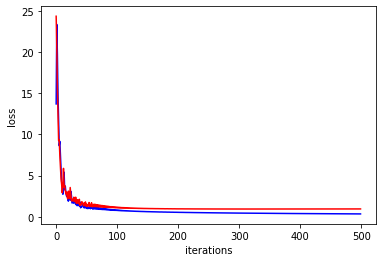

In [18]:
fig = plt.figure()
#print(train_costs)
graph1 = plt.plot(iters, train_costs, 'b')
graph2 = plt.plot(iters, test_costs, 'r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

### **2. Plot the accuracy curve**

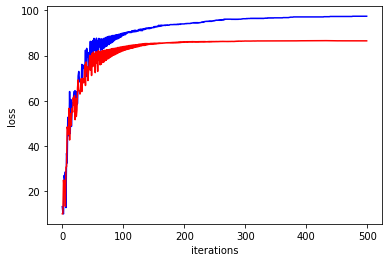

In [19]:
fig = plt.figure()
graph3 = plt.plot(iters, train_accuracys, 'b')
graph4 = plt.plot(iters, test_accuracys, 'r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

### **3. Plot the accuracy value**

In [20]:
final_train_accuracy = train_accuracys[-1]
final_test_accuracy = test_accuracys[-1]
print("final_train_accuracys :", final_train_accuracy,"%")
print("final_test_accuracys :", final_test_accuracy,"%")

final_train_accuracys : 97.39999999999999 %
final_test_accuracys : 86.52222222222223 %


### **4. Plot the classification example**

correct image 10 collections


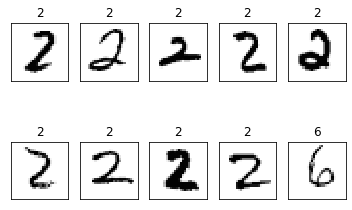

incorrect image 10 collections


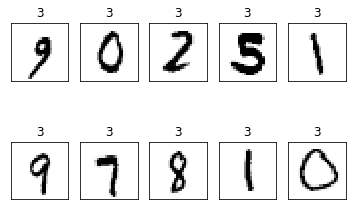

In [21]:
f2 = plt.figure(2)
im_correct  = np.zeros((size_row * size_col, 10), dtype=float)
#print(correct_labels)
#print(correct_labels[0][1])
#print(incorrect_labels)
label_correct_index = []
label_incorrect_index = []

print("correct image 10 collections")
for i in range(10):
    correct_index = correct_labels[0][i]
    im_correct[:, i] += test_image[:, correct_index]
    label_correct_index.append(test_label[correct_index])

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(label_correct_index[i])
    plt.imshow(im_correct[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()
###################################################
#print(incorrect_predicts)

print("incorrect image 10 collections")
f2 = plt.figure(2)
im_incorrect  = np.zeros((size_row * size_col, 10), dtype=float)

for i in range(10):
    incorrect_index = incorrect_labels[0][i]
    im_incorrect[:, i] += test_image[:, incorrect_index]
    label_incorrect_index.append(test_label[incorrect_index])

for i in range(10):
    plt.subplot(2, 5, i+1)
    value = incorrect_predicts[0][i]
    plt.title(value)
    plt.imshow(im_incorrect[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()